In [1]:
import re
import json

import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas

import datasets

# Obtaining ISO country code

In [2]:
# parse iso coutry code from html
with open('data/iso_a3.txt', 'r') as input_:
    html = input_.read()
soup = BeautifulSoup(html, 'html.parser')
table = []
for tr in soup.find_all('tr')[1:]:
    row = []
    for td in tr.find_all('td'):
        row.append(td.string)
    table.append(row)

iso_a3 = pd.DataFrame(table, columns=['English short name', 'French short name', 'Alpha-2 code', 'Alpha-3 code', 'Numeric'])
iso_a3.head()

,English short name,French short name,Alpha-2 code,Alpha-3 code,Numeric
0,Afghanistan,Afghanistan (l'),AF,AFG,004
1,South Africa,Afrique du Sud (l'),ZA,ZAF,710
2,Albania,Albanie (l'),AL,ALB,008
3,Algeria,Algérie (l'),DZ,DZA,012
4,Germany,Allemagne (l'),DE,DEU,276


In [3]:
# mapping from index in the datasets to iso English short name
with open('data/iso_mapping.json', 'r') as i:
    mapping = json.load(i)

# Loading datasets

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[world.name!="Antarctica"]

In [5]:
df_pomber = datasets.pomber()
today = df_pomber.groupby('Country').last()
today.head()

,Cases,Deaths,Recovered
Country,,,
Afghanistan,281,6,10
Albania,304,17,89
Algeria,1171,105,62
Andorra,439,16,16
Angola,8,2,1


In [6]:
df_bno = datasets.bno()
df_bno.head()

,Cases,New cases,Deaths,New deaths,Death rate,Serious & Critical,Recovered
WORLD,,,,,,,
United States,275919.0,31148.0,7335.0,1263.0,2.66,5177.0,10864.0
Italy,119827.0,4585.0,14681.0,766.0,12.25,4068.0,19758.0
Spain,119199.0,7134.0,11198.0,850.0,9.39,6092.0,26743.0
Germany,91203.0,6081.0,1306.0,199.0,1.43,2424.0,30230.0
China,83269.0,84.0,3322.0,4.0,3.99,379.0,76745.0


In [7]:
def mapper(country):
    if country in mapping:
        return mapping[country]
    return country

# conform with iso country name
# datasets are merges with iso_a3 on country code
today.rename(index=mapper, inplace=True)
df_bno.rename(index=mapper, inplace=True)

In [8]:
# world should be merged with the (datasets, iso_a3) on iso_a3
(world.shape,
 world.merge(iso_a3, left_on='iso_a3', right_on='Alpha-3 code').shape,
 world.merge(iso_a3, left_on='name', right_on='English short name').shape)

((176, 6), (171, 11), (137, 11))

## Names that are not found in ISO mapping

In [9]:
set(today.index) - set(iso_a3['English short name'])

{'Diamond Princess', 'Kosovo', 'MS Zaandam'}

In [10]:
set(df_bno.index) - set(iso_a3['English short name'])

{'Diamond Princess',
 'Ivory Coast',
 'Kosovo',
 'Northern Cyprus',
 'Vatican City'}

# Merging DataFrames

In [11]:
intermediate_today = today.merge(iso_a3[['English short name', 'Alpha-3 code']],
                                 left_index=True, right_on='English short name', how='left')
final_today = world[['iso_a3', 'geometry']].merge(intermediate_today,left_on='iso_a3',
                                                  right_on='Alpha-3 code',how='left')
final_today.head()

,iso_a3,geometry,Cases,Deaths,Recovered,English short name,Alpha-3 code
0,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",7.0,0.0,0.0,Fiji,FJI
1,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",20.0,1.0,3.0,"Tanzania, the United Republic of",TZA
2,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN
3,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",12437.0,179.0,2175.0,Canada,CAN
4,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",275586.0,7087.0,9707.0,United States of America (the),USA


In [12]:
intermediate_bno = df_bno.merge(iso_a3[['English short name', 'Alpha-3 code']],
                                left_index=True, right_on='English short name', how='left')
final_bno = world[['iso_a3', 'geometry']].merge(intermediate_bno,left_on='iso_a3',
                                                right_on='Alpha-3 code',how='left')
final_bno.head()

,iso_a3,geometry,Cases,New cases,Deaths,New deaths,Death rate,Serious & Critical,Recovered,English short name,Alpha-3 code
0,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",7.0,0.0,0.0,0.0,0.00,NaN,0.0,Fiji,FJI
1,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",20.0,1.0,1.0,0.0,5.00,NaN,1.0,"Tanzania, the United Republic of",TZA
2,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",12496.0,1213.0,183.0,45.0,1.46,84.0,2189.0,Canada,CAN
4,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",275919.0,31148.0,7335.0,1263.0,2.66,5177.0,10864.0,United States of America (the),USA


# Plotting

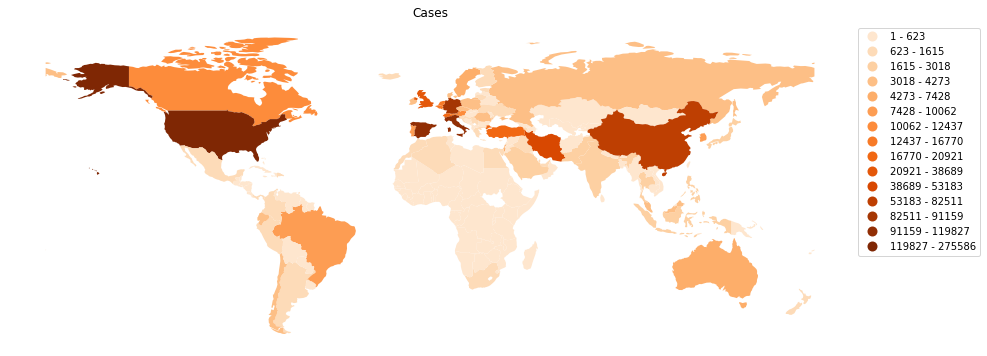

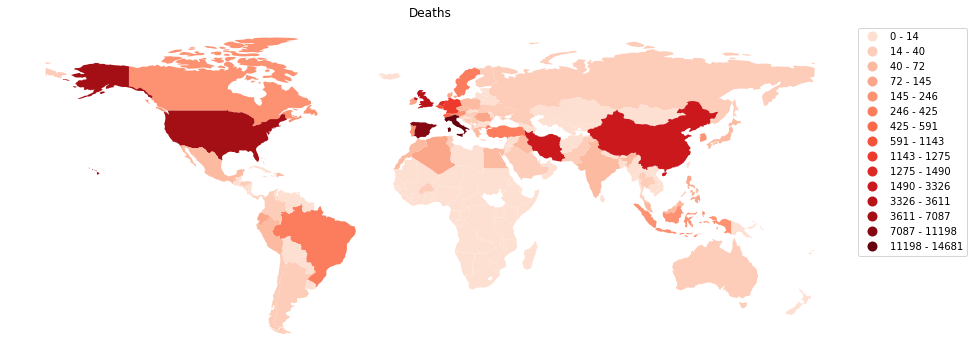

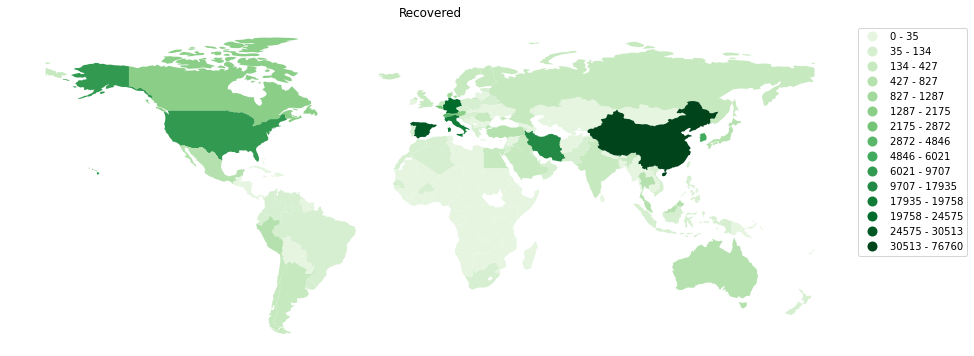

In [13]:
ws = re.compile('\.\d{2}')

def plot_map(data, category, cmap):
    fig, ax = plt.subplots(figsize=(18, 6))
    data.plot(column=category, ax=ax, legend=True, scheme='NaturalBreaks', k=15, cmap=cmap, vmin=-2,
#               missing_kwds={"color": "lightgrey"},
              legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)})
    ax.set_title(category)
    ax.axis('off')
    legend = ax.get_legend()
    for text in legend.get_texts():
        text.set_text(re.sub(ws, '', text.get_text()))
    plt.show()

plot_map(final_today, 'Cases', 'Oranges')
plot_map(final_today, 'Deaths', 'Reds')
plot_map(final_today, 'Recovered', 'Greens')